<a href="https://colab.research.google.com/github/francotestori/aauba_01/blob/nico/ultimo_punto_falta_entrenar_y_evaluar_performance_prueba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje Automático

El objetivo de este trabajo práctico es el desarrollo de una solución que permita predecir la cancelación de una reserva utilizando como dataset el archivo provisto por la catedra ***'hotel_bookins.csv'***.

In [24]:
# Cargar el archivo original de bookings
!wget https://raw.githubusercontent.com/francotestori/aauba_01/master/resources/hotel_bookings.csv

--2020-06-17 00:35:46--  https://raw.githubusercontent.com/francotestori/aauba_01/master/resources/hotel_bookings.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16855599 (16M) [text/plain]
Saving to: ‘hotel_bookings.csv.2’

hotel_bookings.csv. 100%[===================>]  16.07M  26.7MB/s    in 0.6s    

2020-06-17 00:35:47 (26.7 MB/s) - ‘hotel_bookings.csv.2’ saved [16855599/16855599]



In [25]:
!pip install info_gain
from info_gain import info_gain
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date, datetime
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [26]:
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 10000)

bookings_df = pd.read_csv('hotel_bookings.csv')

## a. División en grupos y cuantificación de categorías

---

In [27]:
columnas_categoricas = [
  'hotel', 
  'is_canceled', 
  'meal', 
  'country', 
  'market_segment', 
  'distribution_channel', 
  'is_repeated_guest', 
  'deposit_type', 
  'agent', 
  'company', 
  'customer_type', 
  'reservation_status',
  'arrival_date_month'
]
df_categoricas = bookings_df[columnas_categoricas]

columnas_numericas = [
    'lead_time',  
    'stays_in_weekend_nights', 
    'stays_in_week_nights', 
    'adults', 
    'children', 
    'babies', 
    'previous_cancellations', 
    'previous_bookings_not_canceled', 
    'booking_changes', 
    'days_in_waiting_list', 
    'adr', 
    'required_car_parking_spaces', 
    'total_of_special_requests'                      
]
df_numericas = bookings_df[columnas_numericas]

columnas_ordinales = [
       'reserved_room_type', 
       'assigned_room_type'               
]
df_ordinales = bookings_df[columnas_ordinales]
df_ordinales

def get_month_number(month):
  if month == "January":
    return 1
  elif month == "February":
    return 2   
  elif month == "March":
    return 3   
  elif month == "April":
    return 4   
  elif month == "May":
    return 5   
  elif month == "June":
    return 6   
  elif month == "July":
    return 7   
  elif month == "August":
    return 8   
  elif month == "September":
    return 9   
  elif month == "October":
    return 10
  elif month == "November":
    return 11   
  elif month == "December":
    return 12
  else:
    return 0     

def checkin(year, month_str, day):
  month = get_month_number(month_str)
  return date(year, month, day)

columnas_fecha_hora = [
  'arrival_date_month', 
  'arrival_date_year',
  'arrival_date_day_of_month',   
  'reservation_status_date'               
]
df_fecha_hora = bookings_df[columnas_fecha_hora]
df_fecha_hora['checkin_date'] = df_fecha_hora.apply(
    lambda x: checkin(x['arrival_date_year'], x['arrival_date_month'], x['arrival_date_day_of_month']),
    axis=1
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## b. Valores faltantes

In [28]:
import numpy as np

df=bookings_df

for col in df.columns:
    if df[col].dtype == 'object' and col != 'country':
        df.loc[df[col].str.contains('NULL'), col] = np.nan
        df.loc[df[col].str.contains('Undefined', na=False), col] = np.nan

null_series = df.isnull().sum()

print(null_series[null_series > 0])

children                     4
meal                      1169
country                    488
market_segment               2
distribution_channel         5
agent                    16340
company                 112593
dtype: int64


In [29]:

# Haciendo un análisis inicial contamos con faltantes en los siguientes atributos:
# * **children**: Son muy pocos casos, 4. 
# * **country**: Pocos casos sería posible con alguna medida de cercanía.
# * **agent**: Relativamente grande número de faltantes, 15%.
# * **company**: Número demasiado grande de faltantes, aprox 90%.

# Sin embargo, conocemos que hay otros campos que podrian poseer valores que analogamente representan un valor nulo. 
# Por lo que para esos imputaremos las modas

# Relleno por el valor mas frecuente (moda)
bookings_df['meal'].fillna("BB", inplace = True)
bookings_df['children'].fillna(0.0, inplace = True)
bookings_df['market_segment'].fillna('Online TA', inplace = True)
bookings_df['distribution_channel'].fillna('TA/TO', inplace = True)

# Asigno un desconocido
bookings_df['country'].fillna('XXX', inplace = True)

# Utilizo un valor dummy (máscara) para la presencia de agent y company
bookings_df['agent'] = bookings_df['agent'].isnull()
bookings_df['company'] = bookings_df['company'].isnull()

In [30]:
original_nulls = bookings_df.isnull().sum()

print(original_nulls)

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

## c. Análisis de duplicados

Vamos a analizar si hay reservas duplicadas en nuestro dataframe

In [31]:
duplicated = bookings_df[bookings_df.duplicated()]

# Analizamos el porcentaje de duplicados en base a nuestra muestra
duplicated_ratio = len(duplicated)/len(bookings_df)
print(duplicated_ratio)

# Por elementos **duplicados** entendemos que todas las features de dos filas son identicos.

# Entonces sospechabamos que podría haber casos de una misma reserva que se referenciaba 2 o mas veces en nuestro dataframe.

# Sin embargo y evaluando el peso de los duplicados en nuestro dataframe (26%), entendemos simplemente que son reservas distintas pero con las mismas características.

0.26812128318954687


## c. Variables correlacionadas


In [32]:
corr = bookings_df.corr()
abs(corr.iloc[0,]).sort_values(ascending=False)

# Las cuatro variables más correlacionadas son:

# * **lead_time**                      0.293123
# * **total_of_special_requests**      0.234658
# * **required_car_parking_spaces**    0.195498
# * **booking_changes**                0.144381

is_canceled                       1.000000
lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
agent                             0.102068
company                           0.099310
is_repeated_guest                 0.084793
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005036
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

In [33]:
# PUNTO DE DUDA: CÓMO ELEGIMOS LAS CUATRO MÁS CORRELACIONADAS

# Más allá de la forma, transformamos las variables para que quede un dataset con todas variables en números

# FUNCIONES AUXILIARES
def quantify_room_type(room_type):
    if room_type == 'A':
        return 1
    elif room_type == 'B':
        return 2
    elif room_type == 'C':
        return 3
    elif room_type == 'D':
        return 4
    elif room_type == 'E':
        return 5
    elif room_type == 'F':
        return 6
    elif room_type == 'G':
        return 7
    elif room_type == 'H':
        return 8
    elif room_type == 'I':
        return 9
    elif room_type == 'K':
        return 10
    elif room_type == 'L':
        return 11
    elif room_type == 'P':
        return 12
    else:
        return 0

def room_matches(this_room, other_room):
  match = this_room.lower().replace('s/+',"") == other_room.lower().replace('s/+',"")
  if(match):
    return 1
  else:
    return 0

# CATEGÓRICAS

df_categoricas = bookings_df[columnas_categoricas]

min_dummy = len(df_categoricas)*0.005  # Mínimo de frecuencia para incluir la columna: 0.5% del total
df_categoricas['has_agent'] = bookings_df['agent'].astype(int)
df_categoricas['has_company'] = bookings_df['company'].astype(int)
dummies_cat = pd.get_dummies(
    df_categoricas, 
    columns=[
      'hotel',       
      'market_segment', 
      'meal', 
      'is_repeated_guest', 
      'deposit_type', 
      'customer_type',
      'country',
      'arrival_date_month'
    ], 
    drop_first=False
)
dummies_cat = dummies_cat.iloc[:, 8:]
corr_cat = dummies_cat[dummies_cat.columns[dummies_cat.sum()>min_dummy]]

# ORDINALES
columnas_ordinales = [
       'reserved_room_type', 
       'assigned_room_type'               
]
df_ordinales = bookings_df[columnas_ordinales]
df_ordinales['assigned_room_vl'] = df_ordinales.apply(lambda x: quantify_room_type(x['assigned_room_type']), axis=1)
df_ordinales['requested_room_vl'] = df_ordinales.apply(lambda x: quantify_room_type(x['reserved_room_type']), axis=1)
corr_cat['did_room_match'] = df_ordinales.apply(lambda x: room_matches(x['reserved_room_type'],x['assigned_room_type']), axis=1)
corr_cat['booker_room_gain'] = df_ordinales.apply(lambda x: x['assigned_room_vl'] - x['requested_room_vl'], axis=1)
corr_ord = df_ordinales[['assigned_room_vl', 'requested_room_vl']]

# NUMERICAS
columnas_numericas = [
    'lead_time',  
    'stays_in_week_nights', 
    'stays_in_weekend_nights', 
    'adults', 
    'children', 
    'babies', 
    'previous_cancellations', 
    'previous_bookings_not_canceled',     
    'days_in_waiting_list', 
    'adr', 
    'required_car_parking_spaces', 
    'total_of_special_requests'                      
]
df_numericas = bookings_df[columnas_numericas]

corr_num = df_numericas

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [34]:
# UNION
df_correlations = pd.concat([corr_num,corr_ord,corr_cat],axis=1) 
df_correlations.loc[:,'is_canceled'] = df_categoricas['is_canceled'] 

# El dataset df_correlations restante luego de nuestras transformaciones (encodings)
# termina teniendo todos sus atributos numéricos
# DEBERIAMOS UTILIZARLO EN ADELANTE PARA EL ARMADO DEL ARBOL (?)

In [35]:
corr = df_correlations[df_correlations.columns].corr()['is_canceled'][:-1] 
abs(corr).sort_values(ascending=False)
# RESTARÍA DEFINIR CÓMO ELEGIMOS LAS CUATRO MÁS CORRELACIONADAS, 
# QUE SERÁ EN FUNCIÓN DE LO QUE DEFINIMOS PARA LAS CORRELACIONES

deposit_type_Non Refund           0.481457
deposit_type_No Deposit           0.477911
country_PRT                       0.336122
lead_time                         0.293123
did_room_match                    0.247770
total_of_special_requests         0.234658
market_segment_Groups             0.221859
booker_room_gain                  0.205484
required_car_parking_spaces       0.195498
assigned_room_vl                  0.176028
market_segment_Direct             0.154390
hotel_Resort Hotel                0.136531
customer_type_Transient           0.133084
customer_type_Transient-Party     0.124135
country_FRA                       0.118254
country_GBR                       0.117106
previous_cancellations            0.110133
country_DEU                       0.107316
is_repeated_guest_0               0.084793
is_repeated_guest_1               0.084793
market_segment_Corporate          0.081667
country_ESP                       0.066981
requested_room_vl                 0.061077
adults     

In [36]:
#Defino función cramer's corrected, para categóricas
import scipy.stats as ss
import numpy as np

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [37]:
#Calculo las correlaciones para las categóricas
corr_cat2 = pd.DataFrame(columns=['Atributo', 'Cramers_V_corrected'])

for i in range(len(corr_cat.columns)):
  feature= corr_cat.columns[i]
  confusion_matrix = pd.crosstab(df_categoricas['is_canceled'],corr_cat.iloc[:,i])
  coefficient = cramers_corrected_stat(confusion_matrix)
  corr_cat2.loc[i] = [feature] + [coefficient]

corr_cat2.sort_values('Cramers_V_corrected',ascending=False)

Atributo  Cramers_V_corrected
14        deposit_type_Non Refund             0.481424
13        deposit_type_No Deposit             0.477878
34                    country_PRT             0.336093
51               booker_room_gain             0.248016
50                 did_room_match             0.247728
4           market_segment_Groups             0.221818
3           market_segment_Direct             0.154335
0              hotel_Resort Hotel             0.136483
16        customer_type_Transient             0.133033
17  customer_type_Transient-Party             0.124080
26                    country_FRA             0.118188
27                    country_GBR             0.117042
24                    country_DEU             0.107242
11            is_repeated_guest_0             0.084695
12            is_repeated_guest_1             0.084695
2        market_segment_Corporate             0.081573
25                    country_ESP             0.066885
31                    country_NLD             0.051574
19                    country_BEL             0.049069
28                    country_IRL             0.043611
18                    country_AUT             0.040132
1    market_segment_Complementary             0.039089
8                         meal_FB             0.038613
23                     country_CN             0.036828
37                    country_USA             0.036229
42     arrival_date_month_January             0.030898
21                    country_CHE             0.030680
45       arrival_date_month_March             0.030096
47    arrival_date_month_November             0.029364
44        arrival_date_month_June             0.028865
36                    country_SWE             0.028406
5    market_segment_Offline TA/TO             0.028303
38       arrival_date_month_April             0.024686
33                    country_POL             0.024620
15         customer_type_Contract             0.023445
41    arrival_date_month_February             0.019969
9                         meal_HB             0.019606
29                    country_ISR             0.017964
46         arrival_date_month_May             0.017725
22                    country_CHN             0.017172
49   arrival_date_month_September             0.013352
32                    country_NOR             0.010166
40    arrival_date_month_December             0.010079
7                         meal_BB             0.006512
48     arrival_date_month_October             0.005990
6        market_segment_Online TA             0.005513
30                    country_ITA             0.005372
39      arrival_date_month_August             0.004459
43        arrival_date_month_July             0.000304
20                    country_BRA             0.000000
35                    country_RUS             0.000000
10                        meal_SC             0.000000

In [38]:
#Point Biserial para las categóricas
corr_num2 = pd.DataFrame(columns=['Atributo', 'Point_Biserial'])

for i in range(len(df_numericas.columns)):
  feature2= df_numericas.columns[i]
  coefficient2 = ss.pointbiserialr(df_categoricas['is_canceled'],df_numericas.iloc[:,i])[0]
  corr_num2.loc[i] = [feature2] + [coefficient2]

corr_num2.sort_values('Point_Biserial',ascending=False)

Atributo  Point_Biserial
0                        lead_time        0.293123
6           previous_cancellations        0.110133
3                           adults        0.060017
8             days_in_waiting_list        0.054186
9                              adr        0.047557
1             stays_in_week_nights        0.024765
4                         children        0.005036
2          stays_in_weekend_nights       -0.001791
5                           babies       -0.032491
7   previous_bookings_not_canceled       -0.057358
10     required_car_parking_spaces       -0.195498
11       total_of_special_requests       -0.234658

In [39]:
#Correlaciones ordinales
corr_ord2 = pd.DataFrame(columns=['Atributo', 'Spearman'])

for i in range(len(corr_ord.columns)):
  feature3 = corr_ord.columns[i]
  coefficient3 = ss.spearmanr(df_categoricas['is_canceled'],corr_ord.iloc[:,i])[0]
  corr_ord2.loc[i] = [feature3] + [coefficient3]

corr_ord2.sort_values('Spearman',ascending=False)

Atributo  Spearman
1  requested_room_vl -0.067462
0   assigned_room_vl -0.188455

In [40]:
#Unión de las correlaciones
o1 = corr_ord2 
o1.columns=['Atributo', 'Correlacion']
n1 = corr_num2 
n1.columns=['Atributo', 'Correlacion']
c1 = corr_cat2 
c1.columns=['Atributo', 'Correlacion']
correlaciones= o1.append(n1.append(c1))
correlaciones['Abs(Cor)']=abs(correlaciones['Correlacion'])
correlaciones.sort_values('Abs(Cor)', ascending=False)

Atributo  Correlacion  Abs(Cor)
14         deposit_type_Non Refund     0.481424  0.481424
13         deposit_type_No Deposit     0.477878  0.477878
34                     country_PRT     0.336093  0.336093
0                        lead_time     0.293123  0.293123
51                booker_room_gain     0.248016  0.248016
50                  did_room_match     0.247728  0.247728
11       total_of_special_requests    -0.234658  0.234658
4            market_segment_Groups     0.221818  0.221818
10     required_car_parking_spaces    -0.195498  0.195498
0                 assigned_room_vl    -0.188455  0.188455
3            market_segment_Direct     0.154335  0.154335
0               hotel_Resort Hotel     0.136483  0.136483
16         customer_type_Transient     0.133033  0.133033
17   customer_type_Transient-Party     0.124080  0.124080
26                     country_FRA     0.118188  0.118188
27                     country_GBR     0.117042  0.117042
6           previous_cancellations     0.110133  0.110133
24                     country_DEU     0.107242  0.107242
11             is_repeated_guest_0     0.084695  0.084695
12             is_repeated_guest_1     0.084695  0.084695
2         market_segment_Corporate     0.081573  0.081573
1                requested_room_vl    -0.067462  0.067462
25                     country_ESP     0.066885  0.066885
3                           adults     0.060017  0.060017
7   previous_bookings_not_canceled    -0.057358  0.057358
8             days_in_waiting_list     0.054186  0.054186
31                     country_NLD     0.051574  0.051574
19                     country_BEL     0.049069  0.049069
9                              adr     0.047557  0.047557
28                     country_IRL     0.043611  0.043611
18                     country_AUT     0.040132  0.040132
1     market_segment_Complementary     0.039089  0.039089
8                          meal_FB     0.038613  0.038613
23                      country_CN     0.036828  0.036828
37                     country_USA     0.036229  0.036229
5                           babies    -0.032491  0.032491
42      arrival_date_month_January     0.030898  0.030898
21                     country_CHE     0.030680  0.030680
45        arrival_date_month_March     0.030096  0.030096
47     arrival_date_month_November     0.029364  0.029364
44         arrival_date_month_June     0.028865  0.028865
36                     country_SWE     0.028406  0.028406
5     market_segment_Offline TA/TO     0.028303  0.028303
1             stays_in_week_nights     0.024765  0.024765
38        arrival_date_month_April     0.024686  0.024686
33                     country_POL     0.024620  0.024620
15          customer_type_Contract     0.023445  0.023445
41     arrival_date_month_February     0.019969  0.019969
9                          meal_HB     0.019606  0.019606
29                     country_ISR     0.017964  0.017964
46          arrival_date_month_May     0.017725  0.017725
22                     country_CHN     0.017172  0.017172
49    arrival_date_month_September     0.013352  0.013352
32                     country_NOR     0.010166  0.010166
40     arrival_date_month_December     0.010079  0.010079
7                          meal_BB     0.006512  0.006512
48      arrival_date_month_October     0.005990  0.005990
6         market_segment_Online TA     0.005513  0.005513
30                     country_ITA     0.005372  0.005372
4                         children     0.005036  0.005036
39       arrival_date_month_August     0.004459  0.004459
2          stays_in_weekend_nights    -0.001791  0.001791
43         arrival_date_month_July     0.000304  0.000304
35                     country_RUS     0.000000  0.000000
20                     country_BRA     0.000000  0.000000
10                         meal_SC     0.000000  0.000000

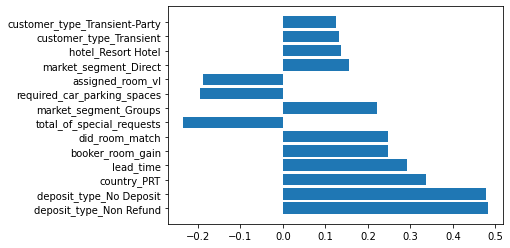

In [41]:
sortedCorr = correlaciones.sort_values('Abs(Cor)', ascending=False)[0:14]
corr = sortedCorr.Atributo
vals = sortedCorr.Correlacion
y_pos = np.arange(len(vals))
plt.barh(y_pos, vals)
plt.yticks(y_pos, corr)
plt.show()


## e. Se encuentra balanceado el set

In [42]:
# Buscamos conocer que tan balanceado está nuestro dataset
bookings_df['is_canceled'].value_counts(normalize=True)

0    0.629584
1    0.370416
Name: is_canceled, dtype: float64

In [43]:
df_correlations['is_canceled'].value_counts(normalize=True)

0    0.629584
1    0.370416
Name: is_canceled, dtype: float64

In [45]:
df_correlations
list(correlaciones.loc[correlaciones['Abs(Cor)']>0.2]['Atributo'])
df_correlations = df_correlations.loc[:,list(correlaciones.loc[correlaciones['Abs(Cor)']>0.2]['Atributo'])]
df_correlations = pd.concat([df_correlations,df_categoricas['is_canceled']],axis=1)




In [54]:
len(list(correlaciones.loc[correlaciones['Abs(Cor)']>0.2]['Atributo']))

8

## g. Implementación Árbol de Decisión

### 1) Arbol de decisión

In [55]:
from sklearn.metrics import fbeta_score

# Con sklearn podemos dividir nuestros datos en conjuntos de entrenamiento, validación y prueba.
# Para el análisis deberiamos utilizar un DF con las variables dummies cargadas
features =  df_correlations.loc[:, df_correlations.columns != 'is_canceled'].columns
target = 'is_canceled'

# Armamos set de datos de dev (0.8) y test (0.2)
x_dev, x_test, y_dev, y_test = train_test_split(
    df_correlations[features].values, 
    df_correlations[target].values, 
    test_size=0.2, 
    random_state=42,
    stratify=df_correlations[target].values
)                           

n_seeds = 50
accs = []
precisions = []
recalls = []
f1s = []
f1s_two = []

for seed in range(n_seeds):
  # Tree Classifier
  arbol_sklearn = DecisionTreeClassifier(max_depth=8)

  # División train-validation
  # x_dev y y_dev son el 80% de mi partición anterior
  # x_train y y_train el 80% de esta partición (0.64)
  # x_val_ y y_val el 20% de esta partición (0.16)
  x_train, x_val, y_train, y_val = train_test_split(
      x_dev, 
      y_dev, 
      test_size=0.2, 
      random_state=seed,
      stratify=y_dev
  ) 

  # Entrenamos al arbol
  arbol_sklearn.fit(x_train,y_train)

  # Ejecutamos nuestra predicción
  y_pred_val = arbol_sklearn.predict(x_val)

  # Medimos (accuracy, precision, recall y f-scores) de nuestra predicción
  accs.append(
      accuracy_score(y_val,y_pred_val)
  )
  precisions.append(
      precision_score(y_val,y_pred_val)
  )
  recalls.append(
      recall_score(y_val,y_pred_val)
  )
  f1s.append(
      f1_score(y_val,y_pred_val)
  )
  f1s_two.append(
      fbeta_score(y_val, y_pred_val, beta=2)
  )

metric_labels = ['Accuracy']*len(accs) + ['Precision']*len(precisions) + ['Recall']*len(recalls) + ['F1 Score']*len(f1s) + ['F2 Score']*len(f1s_two)
all_metrics = accs + precisions + recalls + f1s + f1s_two

wanted_metric_labels = ['Precision']*len(precisions) + ['Recall']*len(recalls) + ['F2 Score']*len(f1s_two)
wanted_metrics = precisions + recalls + f1s_two


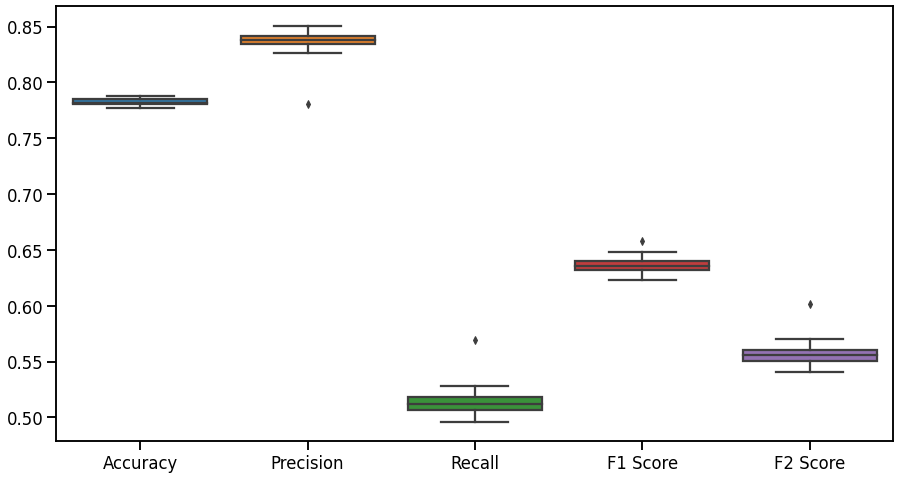

In [56]:
# Boxplots de Métricas
sns.set_context('talk')
plt.figure(figsize=(15,8))
sns.boxplot(metric_labels,all_metrics)

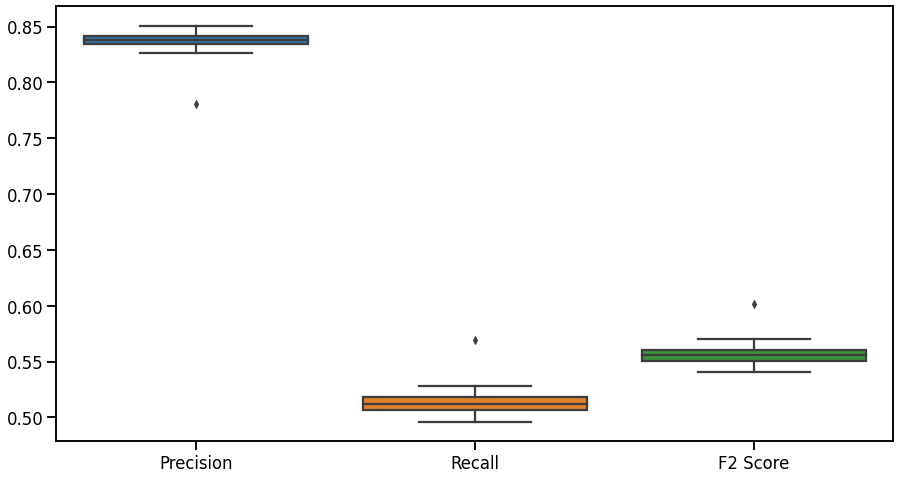

In [57]:
# Boxplots de Métricas Buscadas
sns.set_context('talk')
plt.figure(figsize=(15,8))
sns.boxplot(wanted_metric_labels,wanted_metrics)

### 2) K-fold cross validation

In [58]:
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
import numpy as np

kfold_accs = []
kfold_precisions = []
kfold_recalls = []
kfold_f1s = []
kfold_f1s_two = []

kfoldcv = StratifiedKFold(n_splits=50)

for train_index, test_index in kfoldcv.split(x_dev, y_dev):
  x_train, x_val = x_dev[train_index], x_dev[test_index]
  y_train, y_val = y_dev[train_index], y_dev[test_index]

  # Tree Classifier
  kfold_tree = DecisionTreeClassifier(max_depth=8)

  # Entrenamos al arbol
  kfold_tree.fit(x_train,y_train)

  # Ejecutamos nuestra predicción
  y_pred_val = kfold_tree.predict(x_val)

  # Medimos (accuracy, precision, recall y f-scores) de nuestra predicción
  kfold_accs.append(
      accuracy_score(y_val,y_pred_val)
  )
  kfold_precisions.append(
      precision_score(y_val,y_pred_val)
  )
  kfold_recalls.append(
      recall_score(y_val,y_pred_val)
  )
  kfold_f1s.append(
      f1_score(y_val,y_pred_val)
  )
  kfold_f1s_two.append(
      fbeta_score(y_val, y_pred_val, beta=2)
  )

kfold_metric_labels = ['Accuracy']*len(kfold_accs) + ['Precision']*len(kfold_precisions) + ['Recall']*len(kfold_recalls) + ['F1 Score']*len(kfold_f1s) + ['F2 Score']*len(kfold_f1s_two)
kfold_all_metrics = kfold_accs + kfold_precisions + kfold_recalls + kfold_f1s + kfold_f1s_two

kfold_wanted_metric_labels = ['Precision']*len(kfold_precisions) + ['Recall']*len(kfold_recalls) + ['F2 Score']*len(kfold_f1s_two)
kfold_wanted_metrics = kfold_precisions + kfold_recalls + kfold_f1s_two


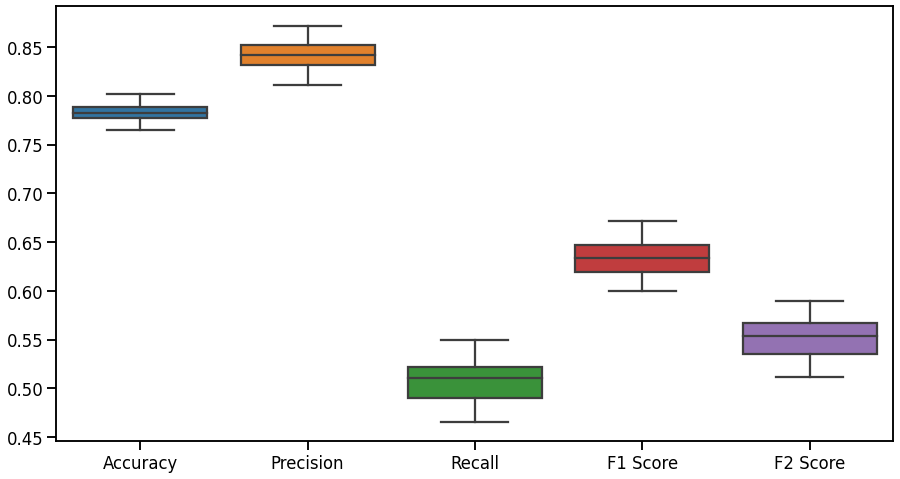

In [59]:
# Boxplots de Métricas
sns.set_context('talk')
plt.figure(figsize=(15,8))
sns.boxplot(kfold_metric_labels,kfold_all_metrics)

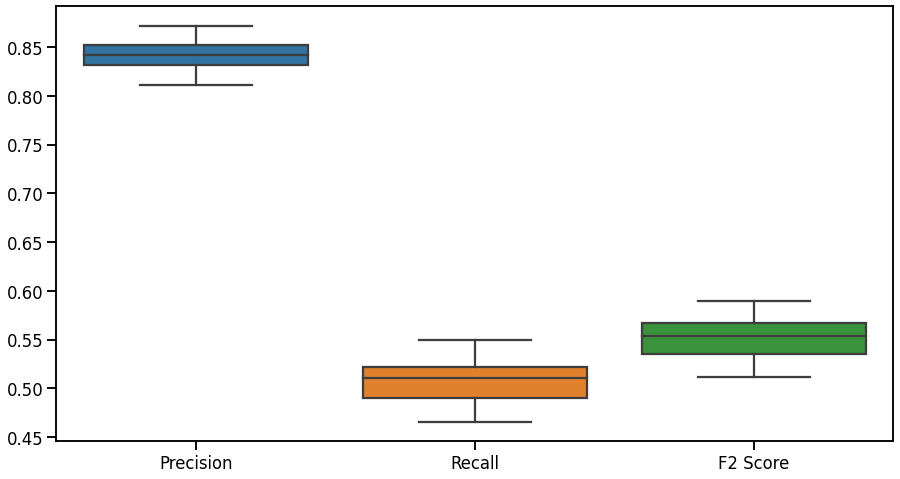

In [60]:
# Boxplots de Métricas Buscadas
sns.set_context('talk')
plt.figure(figsize=(15,8))
sns.boxplot(kfold_wanted_metric_labels,kfold_wanted_metrics)

## h. Graficar Best Tree


In [61]:
best_tree = None
best_score = None

for train_index, test_index in kfoldcv.split(x_dev, y_dev):
  x_train, x_val = x_dev[train_index], x_dev[test_index]
  y_train, y_val = y_dev[train_index], y_dev[test_index]

  # Tree Classifier
  kfold_tree = DecisionTreeClassifier(max_depth=8)

  # Entrenamos al arbol
  kfold_tree.fit(x_train,y_train)

  # Ejecutamos nuestra predicción
  y_pred_val = kfold_tree.predict(x_val)

  f2score = fbeta_score(y_val, y_pred_val, beta=2)

  if best_score is None or best_score < f2score:
    best_score = f2score
    best_tree = kfold_tree



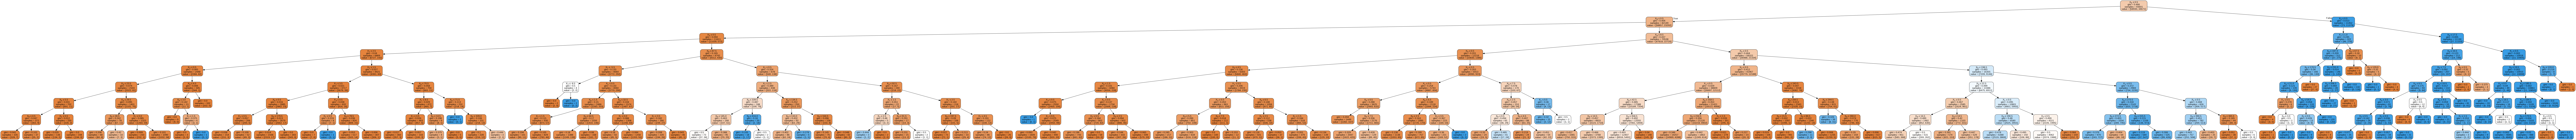

In [62]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib.pyplot as plt

dot_data = StringIO()
export_graphviz(
    best_tree, 
    out_file=dot_data,  
    filled=True, 
    rounded=True,
    special_characters=True
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [63]:
# Podemos pedir el árbol correspondiente ya entrenado y ver cuán importante es cada atributo
feat_imps = best_tree.feature_importances_
feat_imps

array([1.29973937e-01, 4.90564823e-02, 3.58391951e-02, 1.18422194e-04,
       5.91968171e-01, 1.04082741e-01, 8.66916345e-02, 2.26941683e-03])

In [64]:
# Vemos a que variables corresponden los atributos mas importantes
for feat_imp,feat in sorted(zip(feat_imps,features)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

deposit_type_No Deposit: 0.00011842219368247669
booker_room_gain: 0.002269416832936205
market_segment_Groups: 0.03583919508288644
total_of_special_requests: 0.04905648231599127
did_room_match: 0.08669163454190928
country_PRT: 0.10408274148927528
lead_time: 0.1299739366158142
deposit_type_Non Refund: 0.5919681709275048


## i. K-fold y α de poda

In [65]:
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
import numpy as np

kfold_accs = []
kfold_precisions = []
kfold_recalls = []
kfold_f1s = []
kfold_f1s_two = []

kfoldcv = StratifiedKFold(n_splits=10)

for train_index, test_index in kfoldcv.split(x_dev, y_dev):
  x_train, x_val = x_dev[train_index], x_dev[test_index]
  y_train, y_val = y_dev[train_index], y_dev[test_index]

  


# TODO Revisar Antes


### Tunning de hiperparámetros

In [66]:
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
import numpy as np


# Parameter tuning extracted from
# https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
top_range = len(df_correlations.columns)

params_grid = {'criterion':['gini','entropy'],
               'splitter': ['best', 'random'],
               'min_samples_leaf': list(range(1,20)),
               'max_features': ['sqrt','log2'],
               'max_depth':list(range(1,top_range)),
              }

# Nuestra función de scoring es f2 score porque queremos que nuestro algoritmo 
# contemple tanto la precisión como el recall (dandole mas peso a este ultimo)
scorer_fn = make_scorer(fbeta_score, beta=2)

kfoldcv = StratifiedKFold(n_splits=50)

base_tree = DecisionTreeClassifier()
randomcv = RandomizedSearchCV(
    estimator=base_tree,
    param_distributions = params_grid,
    scoring=scorer_fn,
    cv=kfoldcv,
    n_iter = 50,
    random_state = 50
)
randomcv.fit(x_dev,y_dev);

In [67]:
# Guardamos los resultados de K-Fold 
kfold_results = pd.DataFrame(randomcv.cv_results_)

kfold_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_splitter param_min_samples_leaf param_max_features param_max_depth param_criterion                                             params  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  split5_test_score  split6_test_score  split7_test_score  split8_test_score  split9_test_score  split10_test_score  split11_test_score  split12_test_score  split13_test_score  split14_test_score  split15_test_score  split16_test_score  split17_test_score  split18_test_score  split19_test_score  ...  split23_test_score  split24_test_score  split25_test_score  split26_test_score  split27_test_score  split28_test_score  split29_test_score  split30_test_score  split31_test_score  split32_test_score  split33_test_score  split34_test_score  split35_test_score  split36_test_score  split37_test_score  split38_test_score  split39_test_score  split40_test_score  split41_test_score  split42_test_score  split43_test_score  split44_test_score  split45_test_score  split46_test_score  split47_test_score  split48_test_score  split49_test_score  mean_test_score  std_test_score  rank_test_score
0       0.046976      0.006817         0.001946        0.000180           best                      2               log2               7            gini  {'splitter': 'best', 'min_samples_leaf': 2, 'm...           0.568871           0.599051           0.529883           0.622771           0.525184           0.439595           0.593321           0.512104           0.574192           0.450664            0.590909            0.588058            0.545595            0.595926            0.562347            0.611393            0.580371            0.557422            0.618209            0.580831  ...            0.513497            0.611393            0.569449            0.606832            0.572298            0.601560            0.511787            0.546515            0.543312            0.592360            0.595167            0.558940            0.561781            0.527769            0.574939            0.429987            0.401872            0.529628            0.531817            0.574170            0.617412            0.586031            0.583634            0.556065            0.552157            0.534504            0.613616         0.561141        0.049206                4
1       0.021670      0.001676         0.001813        0.000150         random                     18               log2               5         entropy  {'splitter': 'random', 'min_samples_leaf': 18,...           0.525418           0.513337           0.491547           0.472028           0.339039           0.430980           0.430347           0.421187           0.423783           0.399031            0.503282            0.418941            0.470085            0.434084            0.459167            0.555556            0.405712            0.365334            0.418417            0.411803  ...            0.535499            0.419737            0.363577            0.480860            0.407203            0.465227            0.404352            0.439719            0.424952            0.407503            0.357143            0.557751            0.480377            0.397856            0.586819            0.393624            0.346697            0.507314            0.443843            0.391870            0.370915            0.372549            0.431804            0.490654            0.437281            0.411859            0.457298         0.441216        0.055951               22
2       0.015922      0.000910         0.001696        0.000132         random                     17               log2               2         entropy  {'splitter': 'random', 'min_samples_leaf': 17,...           0.393112           0.609516           0.350475           0.408163           0.335968           0.376958           0.364617           0.367527           0.361939           0.381356            0.427833            0.361939   

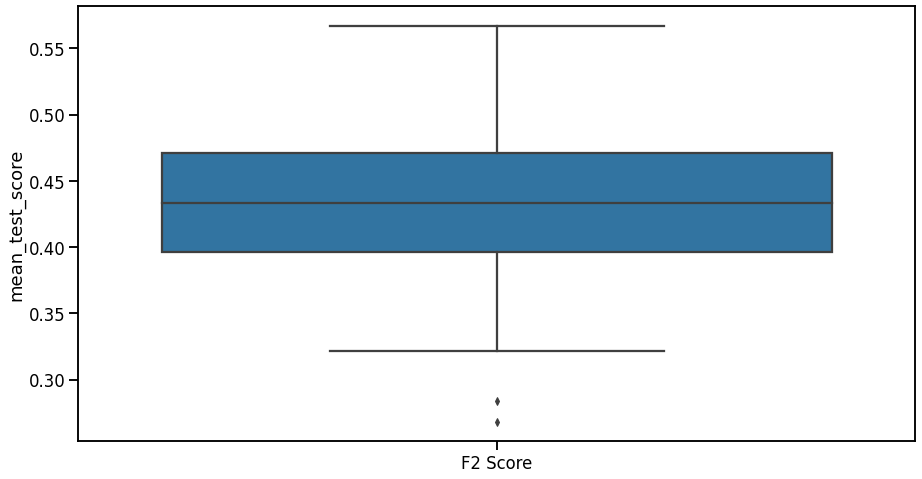

In [68]:
# Boxplots de f2 score en 50-fold cross validation
f2score_metric = kfold_results['mean_test_score']
f2score_label = ['F2 Score']*len(f2score_metric)

sns.set_context('talk')
plt.figure(figsize=(15,8))
sns.boxplot(f2score_label,f2score_metric)

In [69]:
randomcv.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'splitter': 'best'}

Corrimos nuestro análisis de K-Fold, para optimizar hiperparámetros utilizando dos criterios de scoring y obteniendo los siguientes resultados:

*   fbeta2 scorer:
```
{
 'criterion': 'entropy',
 'max_depth': 65,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'splitter': 'best'
}
```



## h. Graficar Best Tree


### i) Gráfico estandar

[Text(403.6595744680851, 509.625, 'deposit_type_No Deposit <= 0.5\ngini = 0.466\nsamples = 95512\nvalue = [60133, 35379]'),
 Text(112.29255319148936, 441.675, 'deposit_type_Non Refund <= 0.5\ngini = 0.029\nsamples = 11850\nvalue = [176, 11674]'),
 Text(47.48936170212766, 373.725, 'market_segment_Groups <= 0.5\ngini = 0.349\nsamples = 133\nvalue = [103, 30]'),
 Text(31.659574468085108, 305.775, 'booker_room_gain <= 1.5\ngini = 0.32\nsamples = 25\nvalue = [5, 20]'),
 Text(23.74468085106383, 237.825, 'lead_time <= 56.5\ngini = 0.236\nsamples = 22\nvalue = [3, 19]'),
 Text(15.829787234042554, 169.875, 'lead_time <= 27.0\ngini = 0.469\nsamples = 8\nvalue = [3, 5]'),
 Text(7.914893617021277, 101.92500000000001, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(23.74468085106383, 101.92500000000001, 'gini = 0.375\nsamples = 4\nvalue = [3, 1]'),
 Text(31.659574468085108, 169.875, 'gini = 0.0\nsamples = 14\nvalue = [0, 14]'),
 Text(39.57446808510638, 237.825, 'gini = 0.444\nsamples = 3\nvalue =

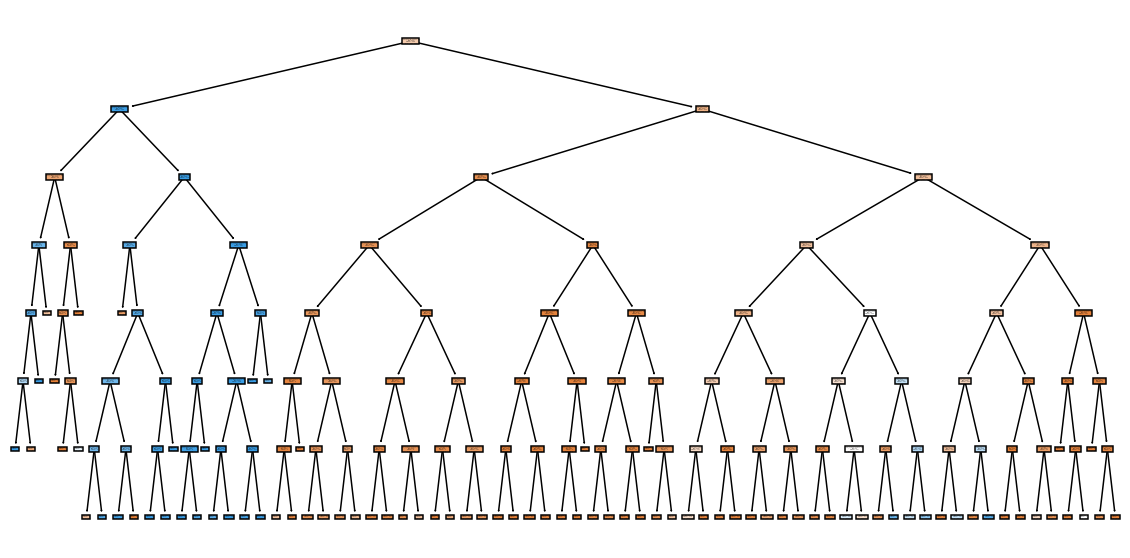

In [70]:
import matplotlib.pyplot as plt

# Tomamos el mejor estimados de nuestro analisis de cross validation
best_tree = randomcv.best_estimator_

#best_tree.fit(x_dev,y_dev)

plt.figure(figsize=(20,10))
plot_tree(
    best_tree,
    feature_names=df_correlations.columns,
    filled=True
)

### ii) Gráfico pydotplus

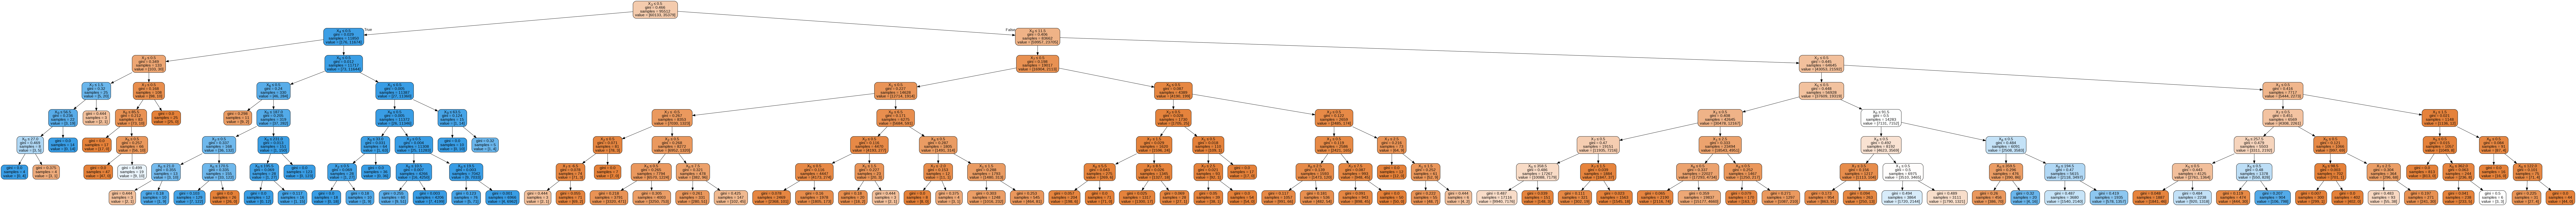

In [71]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib.pyplot as plt

dot_data = StringIO()
export_graphviz(
    best_tree, 
    out_file=dot_data,  
    filled=True, 
    rounded=True,
    special_characters=True
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### iii) Análisis de Best Tree

In [72]:
# Podemos pedir el árbol correspondiente ya entrenado y ver cuán importante es cada atributo
feat_imps = best_tree.feature_importances_
feat_imps

array([0.11638552, 0.05335499, 0.00296889, 0.60401698, 0.00916922,
       0.12557924, 0.04116805, 0.0473571 ])

In [73]:
# Vemos a que variables corresponden los atributos mas importantes
for feat_imp,feat in sorted(zip(feat_imps,features)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

market_segment_Groups: 0.00296888666908962
deposit_type_Non Refund: 0.009169217396873614
did_room_match: 0.041168050841946774
booker_room_gain: 0.04735710354958989
total_of_special_requests: 0.05335499251147935
lead_time: 0.11638551979008081
country_PRT: 0.12557924488176536
deposit_type_No Deposit: 0.6040169843591746


## i. K-fold y α de poda

In [74]:
x_train_sets = []
x_val_sets = []
y_train_sets = []
y_val_sets = []

# Armo mis splits train-val
for index in range(10):
  x_train, x_val, y_train, y_val = train_test_split(
        x_dev, 
        y_dev, 
        test_size=0.2, 
        random_state=seed,
        stratify=y_dev
    )
  x_train_sets.append(x_train)
  x_val_sets.append(x_val)
  y_train_sets.append(y_train)
  y_val_sets.append(y_val)

# Tree Classifier
ccp_tree = DecisionTreeClassifier(
    criterion='entropy',
    splitter = 'best',
    max_features =  'sqrt',
    max_depth=65,
    min_samples_leaf=2
)

# Calculos los 
ccp_path = ccp_tree.cost_complexity_pruning_path(x_train,y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

NameError: ignored

In [75]:
# Vamos a podar nuestra arbol mejor clasificado
clf = randomcv.best_estimator_
path = clf.cost_complexity_pruning_path(x_train,y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [76]:
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
import numpy as np

params_grid = {'ccp_alpha':filtered}
scorer_fn = make_scorer(fbeta_score, beta=2)

kfoldcv = StratifiedKFold(n_splits=10)

base_tree = DecisionTreeClassifier(
    random_state=0, 
    criterion = 'entropy',
    max_depth = 28 
)

randomcv = RandomizedSearchCV(
    estimator = base_tree,
    param_distributions = params_grid,
    scoring=scorer_fn,
    cv=kfoldcv,
    n_iter = 10,
    random_state = 50
)
randomcv.fit(x_train,y_train);

NameError: ignored

## Analizamos metricas K-Fold


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

best_model = randomcv.best_estimator_
y_pred = best_model.predict(x_test)

print(
    classification_report(y_test,y_pred)
)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     15033
           1       0.79      0.80      0.80      8845

    accuracy                           0.85     23878
   macro avg       0.84      0.84      0.84     23878
weighted avg       0.85      0.85      0.85     23878



Text(19.5, 0.5, 'True')

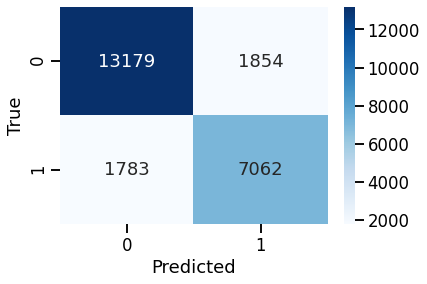

In [ ]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:330: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:330: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)


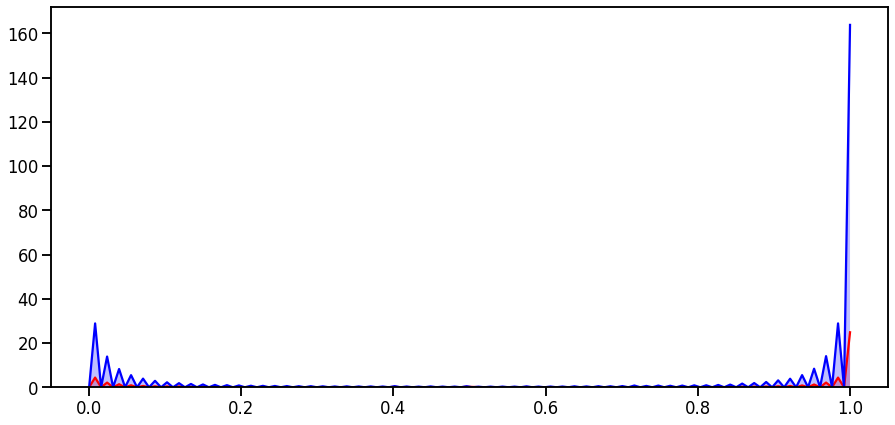

In [ ]:
y_scores = best_model.predict_proba(x_test)
out_probs = y_scores[:,1]

plt.figure(figsize=(15,7))
sns.kdeplot(out_probs[y_test==0],shade=True,c='r')
sns.kdeplot(out_probs[y_test==1],shade=True,c='b')

## g. Poda de Arbol

In [ ]:
# Vamos a podar nuestra arbol mejor clasificado
clf = randomcv.best_estimator_
path = clf.cost_complexity_pruning_path(x_train,y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
ccp_alphas


array([0.        , 0.        , 0.        , ..., 0.01812787, 0.01831502,
       0.10866758])

In [ ]:
impurities

array([0.00930319, 0.00930319, 0.00930319, ..., 0.28448736, 0.35774746,
       0.46641504])

Text(0, 0.5, 'total impurity of leaves')

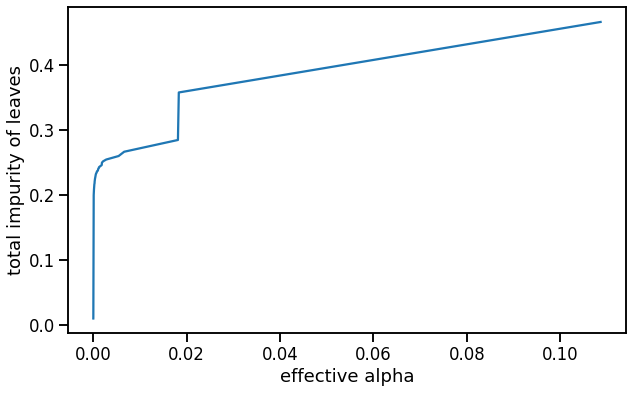

In [ ]:
# Graficamos el cost complexity pruning path de nuestro arbol
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities)
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")

In [ ]:
filter_arr = []

# go through each element in arr
for element in impurities:
  # if the element is completely divisble by 2, set the value to True, otherwise False
  if element > 0.24:
    filter_arr.append(True)
  else:
    filter_arr.append(False)


filtered = ccp_alphas[filter_arr]
print(len(filtered))

14


## i. Alpha K-Fold Validation 

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
import numpy as np

params_grid = {'ccp_alpha':filtered}

kfoldcv = StratifiedKFold(n_splits=10)
base_tree = DecisionTreeClassifier(
    random_state=0, 
    criterion = 'entropy',
    max_depth = 28 
)
scorer_fn = make_scorer(fbeta_score, beta=2)
randomcv = RandomizedSearchCV(
    estimator = base_tree,
    param_distributions = params_grid,
    scoring=scorer_fn,
    cv=kfoldcv,
    n_iter = 10,
    random_state = 50
)
randomcv.fit(x_train,y_train);

In [ ]:
# Guardamos los resultados de K-Fold 
prune_kfold = pd.DataFrame(randomcv.cv_results_)
print(len(prune_kfold))
prune_kfold

10


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_ccp_alpha                                params  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  split5_test_score  split6_test_score  split7_test_score  split8_test_score  split9_test_score  mean_test_score  std_test_score  rank_test_score
0       1.240388      0.015923         0.006755        0.000112        0.018315   {'ccp_alpha': 0.018315023990871926}           0.774068           0.766059           0.778528           0.775358           0.774683           0.781658           0.766397           0.778741           0.772102           0.784570         0.775216        0.005704                1
1       1.234455      0.018214         0.006761        0.000144       0.0066154  {'ccp_alpha': 0.0066154043863585615}           0.774068           0.766059           0.778528           0.775358           0.774683           0.781658           0.766397           0.778741           0.772102           0.784570         0.775216        0.005704                1
2       1.260067      0.024903         0.006806        0.000104      0.00542059   {'ccp_alpha': 0.005420585620468585}           0.774068           0.766059           0.778528           0.775358           0.774683           0.781658           0.766397           0.778741           0.772102           0.784570         0.775216        0.005704                1
3       1.253161      0.006653         0.006858        0.000177      0.00146567  {'ccp_alpha': 0.0014656697042258887}           0.772801           0.724592           0.777057           0.717153           0.747241           0.739271           0.689858           0.713457           0.769729           0.772344         0.742350        0.028905                5
4       1.242069      0.023379         0.006795        0.000133      0.00121746  {'ccp_alpha': 0.0012174582100064474}           0.729660           0.726565           0.727473           0.739949           0.738630           0.740986           0.717980           0.729780           0.732172           0.724911         0.730810        0.006936                6
5       1.234883      0.024768         0.006734        0.000105      0.00209293   {'ccp_alpha': 0.002092927966462592}           0.697335           0.695711           0.701369           0.702063           0.707498           0.711039           0.688614           0.698585           0.702057           0.698396         0.700267        0.005894               10
6       1.218990      0.016125         0.006716        0.000100      0.00275969   {'ccp_alpha': 0.002759690931199786}           0.773484           0.764650           0.778966           0.776103           0.773773           0.783411           0.767422           0.699305           0.771293           0.784215         0.767262        0.023422                4
7       1.230827      0.017612         0.006801        0.000282      0.00181693  {'ccp_alpha': 0.0018169274904004107}           0.711052           0.711967           0.714286           0.717153           0.723407           0.725191           0.704475           0.713457           0.716068           0.711167         0.714822        0.005772                7
8       1.254244      0.009580         0.006748        0.000122      0.00184403   {'ccp_alpha': 0.001844032657149039}           0.711052           0.711967           0.714286           0.702063           0.723407           0.725191           0.688178           0.713457           0.716068           0.711167         0.711683        0.009974                9
9       1.258240      0.009360         0.007014        0.000798      0.00180023  {'ccp_alpha': 0.0018002286773838583}           0.711052           0.711967           0.714286           0.717153           0.723407           0.725191           0.704475           0.713457           0.716068           0.711167         0.714822        0.005772                7

In [ ]:
for clf in :


SyntaxError: ignored

In [ ]:
randomcv.best_params_

In [ ]:
filtered

In [ ]:
# Vamos a buscar el valor óptimo de alpha para nuestro arbol
clfs = []

for ccp_alpha in filtered:
    clf = DecisionTreeClassifier(
        random_state=0, 
        ccp_alpha=ccp_alpha,
        criterion = 'entropy',
        max_depth = 28
    )
    clf.fit(x_train, y_train)
    clfs.append(clf)

In [ ]:
# Graficamos la relación entre alpha y la profundidad de nuestro arbol

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(filtered[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")

In [ ]:
# Graficamos el alpha que mejora nuestro fbeta score
from sklearn.metrics import fbeta_score

fbeta2_scores = [fbeta_score(y_test, clf.predict(x_test), beta=2) for clf in clfs]

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(filtered[:-1], fbeta2_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("FBeta2 scores")

##j. Comparar alpha y arbol sin poda

Armar dos arboles con alpha distintos (apha elegido y alpha 0), entrenarlos y comparar la validacion


In [ ]:
x_train_, x_val_, y_train_, y_val_ = train_test_split(
      x_train, 
      y_train, 
      test_size=0.2, 
      random_state=seed,
      stratify=y_train
)



In [82]:
x_dev

array([[ 20,   0,   0, ...,   0,   1,   0],
       [  8,   0,   1, ...,   0,   1,   0],
       [ 93,   0,   0, ...,   1,   1,   0],
       ...,
       [135,   2,   0, ...,   0,   1,   0],
       [172,   1,   0, ...,   0,   1,   0],
       [223,   0,   1, ...,   0,   1,   0]])

In [78]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [79]:
X = x_dev
target = y_dev
scorer_fn = make_scorer(fbeta_score, beta=2)
rfc = RandomForestClassifier(random_state=101)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(2 ), scoring=scorer_fn)
rfecv.fit(X, target)

RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=101,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None,
      scoring=make_scorer(fbeta_score, beta=2), step=1, verbose=0)

In [80]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 8


In [81]:
X = pd.DataFrame(x_dev)
X.columns=df_correlations.columns[:-1]
target = pd.DataFrame(y_dev)
target.columns=[df_correlations.columns[len(df_correlations.columns)-1]]



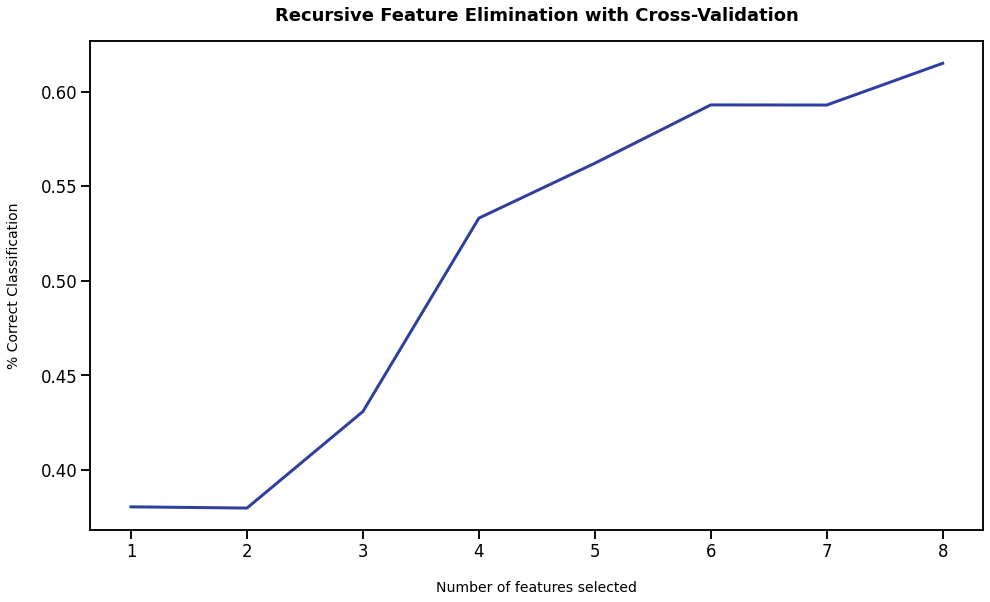

In [82]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [83]:
print(np.where(rfecv.support_ == False)[0])

X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[]


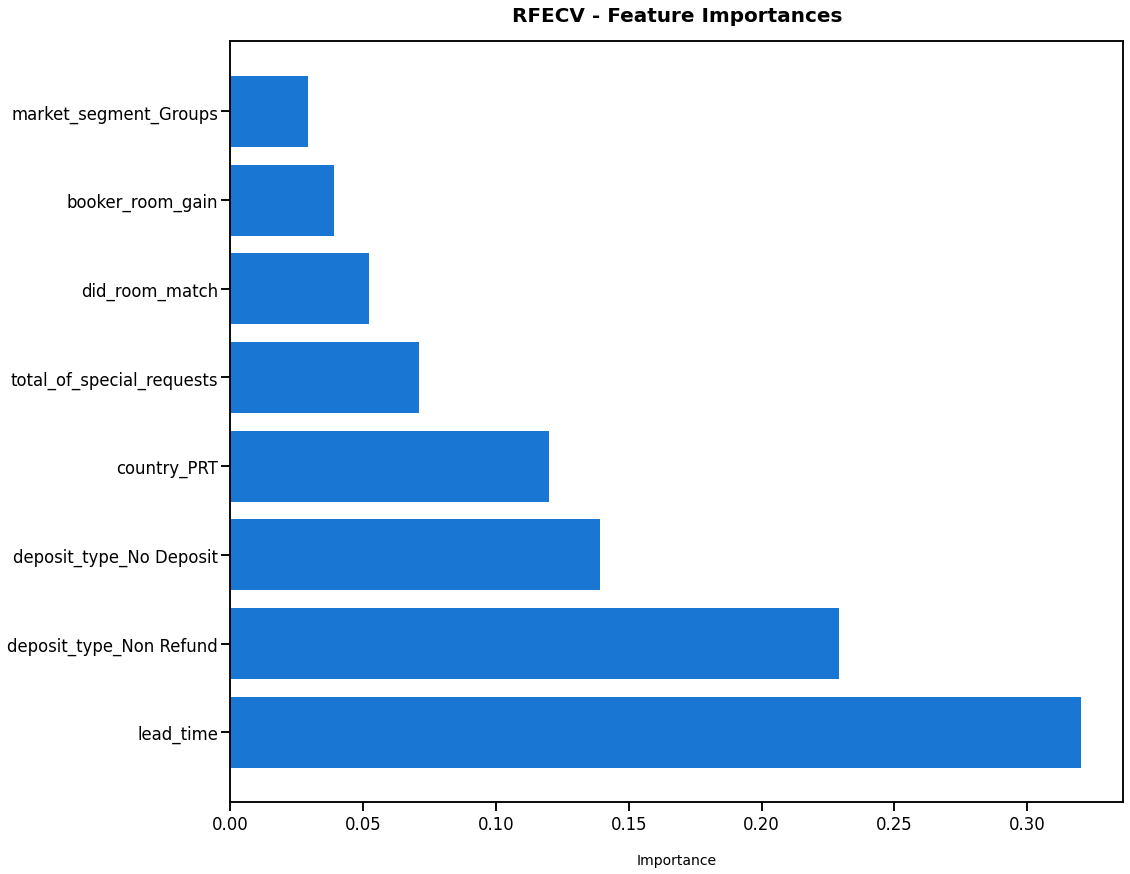

In [84]:
dset = pd.DataFrame()
dset['attr'] = X.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [85]:
x_dev

array([[ 20,   0,   0, ...,   0,   1,   0],
       [  8,   0,   1, ...,   0,   1,   0],
       [ 93,   0,   0, ...,   1,   1,   0],
       ...,
       [135,   2,   0, ...,   0,   1,   0],
       [172,   1,   0, ...,   0,   1,   0],
       [223,   0,   1, ...,   0,   1,   0]])

['lead_time',
 'deposit_type_Non Refund',
 'deposit_type_No Deposit',
 'country_PRT']

In [99]:
filtro=list(dset.sort_values(by='importance', ascending=False).head(4)['attr'])
df_correlations = df_correlations.loc[:,filtro]
df_correlations = pd.concat([df_correlations,df_categoricas['is_canceled']],axis=1)
df_correlations = df_correlations.drop(['deposit_type_No Deposit'], axis=1)
df_correlations

lead_time  deposit_type_Non Refund  country_PRT  is_canceled
0             342                        0            1            0
1             737                        0            1            0
2               7                        0            0            0
3              13                        0            0            0
4              14                        0            0            0
...           ...                      ...          ...          ...
119385         23                        0            0            0
119386        102                        0            0            0
119387         34                        0            0            0
119388        109                        0            0            0
119389        205                        0            0            0

[119390 rows x 4 columns]